# GaN ML Model Start Here 

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# Read Data
data = pd.read_csv('./data_0918_PCA.csv')
X = data[['L_gp', 'R_gp', 'Thick_gp', 'SFP_Loc', 'SFP_Len', 'Thick_sfp', 'Oxide_Thick']]
y = data[data.columns[8:11]]
X

,L_gp,R_gp,Thick_gp,SFP_Loc,SFP_Len,Thick_sfp,Oxide_Thick
0,0.4,1.2,0.2,0.00,0.0,0.0,0.0
1,0.4,0.4,0.2,0.00,0.0,0.0,0.0
2,0.4,0.8,0.2,0.00,0.0,0.0,0.0
3,0.4,0.4,0.4,0.00,0.0,0.0,0.0
4,0.4,0.2,0.6,3.25,0.4,0.4,0.0
...,...,...,...,...,...,...,...
464,0.4,0.6,0.6,2.65,0.8,0.2,0.1
465,0.4,0.6,0.6,2.65,0.8,0.4,0.1
466,0.4,0.6,0.6,2.65,0.8,0.6,0.1
467,0.4,0.6,0.6,2.65,0.8,0.2,0.2


In [ ]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_all = scaler.transform(X)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 3)
X_all = torch.tensor(np.array(X_all), dtype=torch.float32).to(device)

y_train_1 = y_train[:, 0].reshape(-1, 1).to(device)
y_train_2 = y_train[:, 1].reshape(-1, 1).to(device)
y_train_3 = y_train[:, 2].reshape(-1, 1).to(device)

X_test = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 3)
y_test_1 = y_test[:, 0].reshape(-1, 1).to(device)
y_test_2 = y_test[:, 1].reshape(-1, 1).to(device)
y_test_3 = y_test[:, 2].reshape(-1, 1).to(device)

y_all = torch.tensor(np.array(y), dtype=torch.float32).reshape(-1, 3)
y_all_1 = y_all[:, 0].reshape(-1, 1).to(device)
y_all_2 = y_all[:, 1].reshape(-1, 1).to(device)
y_all_3 = y_all[:, 2].reshape(-1, 1).to(device)

# Training from saved model

In [ ]:
# Define the model version 2
class NeuralNetwork(nn.Module):
    def __init__(self, l1=100, l2=50, l3=15, dr=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.SharedLinear = nn.Linear(7, l1)
        self.NN_stack_1 = nn.Sequential(
            nn.Softplus(),
            nn.LayerNorm(l1),
            nn.Dropout(p=dr),
            nn.Linear(l1, l2),
            nn.ELU(),
            nn.LayerNorm(l2),
            nn.Dropout(p=dr),
            nn.Linear(l2, l3),
            nn.Softplus(),
            nn.LayerNorm(l3),
            nn.Dropout(dr),
            nn.Linear(l3, 1)
        )
        self.NN_stack_2 = nn.Sequential(
            nn.Softplus(),
            nn.LayerNorm(l1),
            nn.Dropout(p=dr),
            nn.Linear(l1, 20),
            nn.Softplus(),
            nn.LayerNorm(20),
            nn.Dropout(p=dr),
            nn.Linear(20, l3),
            nn.Softplus(),
            nn.LayerNorm(l3),
            nn.Dropout(dr),
            nn.Linear(l3, 1)
        )
        self.NN_stack_3 = nn.Sequential(
            nn.Softplus(),
            nn.LayerNorm(l1),
            nn.Dropout(p=dr),
            nn.Linear(l1, l2),
            nn.ELU(),
            nn.LayerNorm(l2),
            nn.Dropout(dr),
            nn.Linear(l2, l3),
            nn.Softplus(),
            nn.LayerNorm(l3),
            nn.Dropout(dr),
            nn.Linear(l3, 1)
        ) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.SharedLinear(x)
        #x = self.Tanh1(x)
        GaN_NN_output1 = self.NN_stack_1(x)
        GaN_NN_output2 = self.NN_stack_2(x)
        GaN_NN_output3 = self.NN_stack_3(x)
        return GaN_NN_output1, GaN_NN_output2, GaN_NN_output3

In [7]:
#torch.save(model, './Ray_GaN_Best_Opt_200_45_15.pth')
model = torch.load('Ray_GaN_Best_Opt_200_100_20_dr4_ba8_3hid4leak.pth', map_location=torch.device(device))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (SharedLinear): Linear(in_features=7, out_features=200, bias=True)
  (NN_stack_1): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ELU(alpha=1.0)
    (5): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=100, out_features=15, bias=True)
    (8): Softplus(beta=1, threshold=20)
    (9): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Linear(in_features=15, out_features=1, bias=True)
  )
  (NN_stack_2): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=20, bias=True)
    (4): Softp

In [8]:
y_pred_BV, y_pred_leak, y_pred_Cgd = model(X_all)
y_test_BV, y_test_leak, y_test_Cgd = model(X_test)
y_train_BV, y_train_leak, y_train_Cgd = model(X_train)

In [28]:
X_test.shape

torch.Size([94, 7])

In [8]:
y['BV'].std(), y['Leakage_2'].std(), y['Cgd_2'].std()

(60.85868513675184, 1.4809058833652768, 13.367821317791208)

Adam Model: ELU for Cgg and BV first hid layer 100 -> 50 -> 15 100 -> 15 -> 1 

Testing:(22.798141350194264, 0.3827191063754747, 2.408284008836586)

Training:(20.449706372529075, 0.2706389539658341, 0.3346236952968922)

In [9]:
import math
import numpy as np

rmse_BV = math.sqrt(np.square(y_test_BV.cpu().detach().numpy().reshape(len(y_test_BV))
                              - y_test_1.cpu().detach().numpy().reshape(len(y_test_BV))).mean())
rmse_Leak = math.sqrt(np.square(y_test_leak.cpu().detach().numpy().reshape(len(y_test_BV))
                              - y_test_2.cpu().detach().numpy().reshape(len(y_test_BV))).mean())
rmse_Cgd = math.sqrt(np.square(y_test_Cgd.cpu().detach().numpy().reshape(len(y_test_BV))
                              - y_test_3.cpu().detach().numpy().reshape(len(y_test_BV))).mean())
rmse_BV, rmse_Leak, rmse_Cgd

(27.750732412209636, 0.5898322552704083, 2.1027509881074984)

In [10]:
rmse_BV_train = math.sqrt(np.square(y_train_BV.cpu().detach().numpy().reshape(len(y_train_BV))
                              - y_train_1.cpu().detach().numpy().reshape(len(y_train_BV))).mean())
rmse_Leak_train = math.sqrt(np.square(y_train_leak.cpu().detach().numpy().reshape(len(y_train_BV))
                              - y_train_2.cpu().detach().numpy().reshape(len(y_train_BV))).mean())
rmse_Cgd_train = math.sqrt(np.square(y_train_Cgd.cpu().detach().numpy().reshape(len(y_train_BV))
                              - y_train_3.cpu().detach().numpy().reshape(len(y_train_BV))).mean())
rmse_BV_train, rmse_Leak_train, rmse_Cgd_train

(20.826250179357856, 0.36485301216343763, 1.7608954626852131)

In [16]:
len(y_all_1)

488

***Record***

Before Outlier Removal (Best: full_model_ELU_Cgd+BV_1nd_20000_0918.pth)

Testing: (39.78519287706954, 1.295734639513373, 2.400035412845018)

Training: (23.321869713502682, 0.8743961498546559, 0.8743961498546559)

R_square: 0.9110444991896998 0.8639302047835611 0.9927061741614109

After Outlier Removal (Best: full_model_ELU_Cgd+BV_1st_10000_0918_PCA.pth)

Testing: (36.46051648969488, 0.669056837155049, 2.2947513857882087)

Training: (14.612391065676075, 0.31747299086964376, 0.31747299086964376)

R_square: 0.9419571064339968 0.961843877103093 0.994475644147742

150-30-15 10000

Testing: (37.024119171029916, 0.9036948257635856, 2.0813972123236715)

Training: (20.380438517606088, 0.44051311235689194, 0.44051311235689194)

R_square: 0.9189336102553024 0.9271871176973032 0.9923481212067273

200-45-20 Ray

Testing: (19.809890527090566, 0.44605878569339463, 1.8778436713473157)

Training: (10.724074217491486, 0.2817431074287745, 0.2817431074287745)

R_square: 0.9769033320158182 0.9761323047959727 0.9958974821926081


In [36]:
import scipy.stats as stats

# Calculate the r squared value
r_squared_1 = stats.pearsonr(y_all_1.cpu().detach().numpy().reshape(len(y_all_1)),
                             y_pred_BV.cpu().detach().numpy().reshape(len(y_all_1)))[0]
r_squared_2 = stats.pearsonr(y_all_2.cpu().detach().numpy().reshape(len(y_all_1)),
                             y_pred_leak.cpu().detach().numpy().reshape(len(y_all_1)))[0]
r_squared_3 = stats.pearsonr(y_all_3.cpu().detach().numpy().reshape(len(y_all_1)),
                             y_pred_Cgd.cpu().detach().numpy().reshape(len(y_all_1)))[0]

print(r_squared_1, r_squared_2, r_squared_3)

0.9366688073706368 0.9607558943369523 0.9922836500424504


In [142]:
len(y_test_1)

94

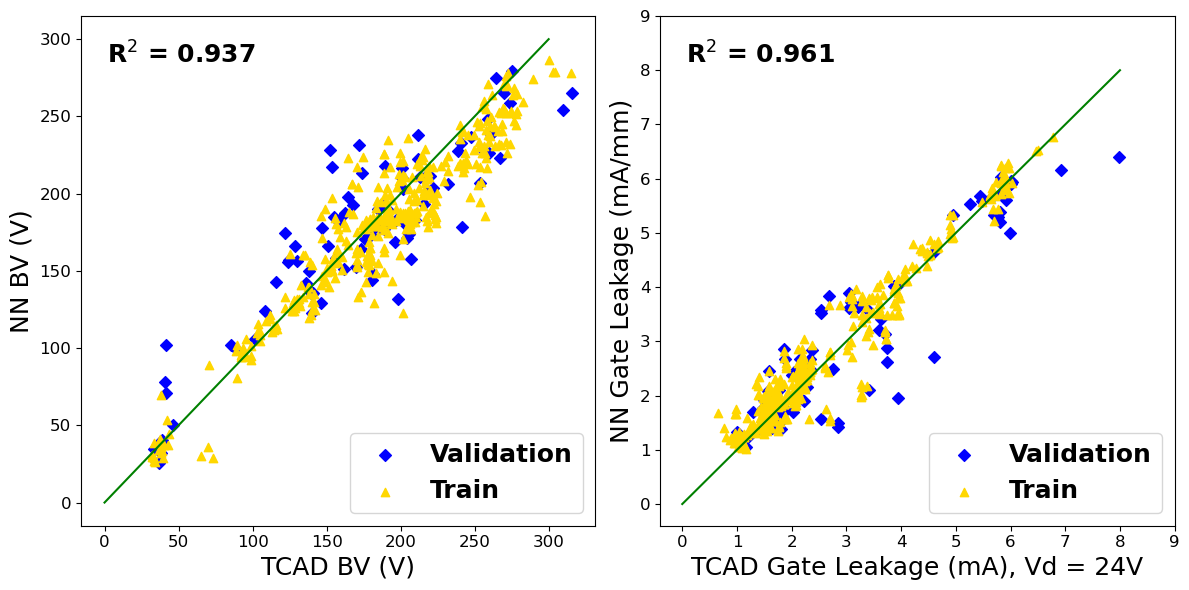

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of subplots with two columns
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2)

# Create two axes for the subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot data on the first subplot
x = np.linspace(0, 300, 100)
ax1.plot(x, x, color='green', linestyle='-')
ax1.scatter(y_test_1.cpu().detach().numpy().reshape(len(y_test_1)),
            y_test_BV.cpu().detach().numpy().reshape(len(y_test_1)),
            color='b', marker='D', label='Validation')
ax1.scatter(y_train_1.cpu().detach().numpy().reshape(len(y_train_1)),
            y_train_BV.cpu().detach().numpy().reshape(len(y_train_1)),
            color='gold', marker='^', label='Train')
# Add text to the upper-left corner of the first subplot
ax1.text(0.05, 0.95, 'R$^2$ = 0.937', transform=ax1.transAxes,
         va='top', ha='left', fontsize=18, color='black', fontweight='bold')
ax1.set_xticks(np.arange(0, 350, 50))
ax1.set_yticks(np.arange(0, 350, 50))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel('TCAD BV (V)', fontsize=18)
ax1.set_ylabel('NN BV (V)', fontsize=18)
ax1.legend(loc='lower right', prop={'weight': 'bold', 'size': 18})


# Plot data on the second subplot
#ax2.plot(x, y2)
#ax2.set_title('Plot 2')

# Plot data on the first subplot
x = np.linspace(0.0, 8, 100)
ax2.plot(x, x, color='green', linestyle='-')
ax2.scatter(y_test_2.cpu().detach().numpy().reshape(len(y_test_2)),
            y_test_leak.cpu().detach().numpy().reshape(len(y_test_2)),
            color='b', marker='D', label='Validation')
ax2.scatter(y_train_2.cpu().detach().numpy().reshape(len(y_train_2)),
            y_train_leak.cpu().detach().numpy().reshape(len(y_train_2)),
            color='gold', marker='^', label='Train')
# Add text to the upper-left corner of the first subplot
ax2.text(0.05, 0.95, 'R$^2$ = 0.961', transform=ax2.transAxes,
         va='top', ha='left', fontsize=18, color='black', fontweight='bold')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_yticks(np.arange(0, 10, 1))
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel('TCAD Gate Leakage (mA), Vd = 24V', fontsize=18)
ax2.set_ylabel('NN Gate Leakage (mA/mm)', fontsize=18)
ax2.legend(loc='lower right', prop={'weight': 'bold', 'size': 18})

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('./Plots/R_square_BV_Leak.pdf', format="pdf", bbox_inches="tight")
# Show the plots
plt.show()


In [51]:
y['Cgd_2'].max

81.38947368421053

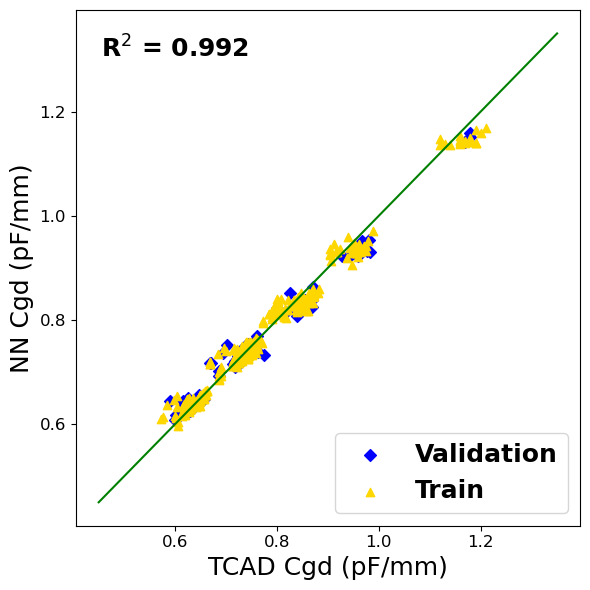

In [14]:
# Create a grid of subplots with two columns
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(1, 1)

# Create two axes for the subplots
ax = fig.add_subplot(gs[0, 0])
# Plot data on the first subplot
x = np.linspace(45, 135, 100)
ax.plot(x/1e2, x/1e2, color='green', linestyle='-')
ax.scatter(y_test_3.cpu().detach().numpy().reshape(len(y_test_3))/1e2,
            y_test_Cgd.cpu().detach().numpy().reshape(len(y_test_3))/1e2,
            color='b', marker='D', label='Validation')
ax.scatter(y_train_3.cpu().detach().numpy().reshape(len(y_train_3))/1e2,
            y_train_Cgd.cpu().detach().numpy().reshape(len(y_train_3))/1e2,
            color='gold', marker='^', label='Train')
# Add text to the upper-left corner of the first subplot
ax.text(0.05, 0.95, 'R$^2$ = 0.992', transform=ax.transAxes,
         va='top', ha='left', fontsize=18, color='black', fontweight='bold')
#ax.set_xticks(np.arange(12, 22, 3))
#ax.set_yticks(np.arange(12, 22, 3))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('TCAD Cgd (pF/mm)', fontsize=18)
ax.set_ylabel('NN Cgd (pF/mm)', fontsize=18)
ax.legend(loc='lower right', prop={'weight': 'bold', 'size': 18})

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('./Plots/R_square_Cgd.pdf', format="pdf", bbox_inches="tight")
# Show the plots
plt.show()

# Pymoo Optimization start here

In [15]:
import warnings
# Create a filter to ignore the warning
warnings.filterwarnings('ignore', category=UserWarning)
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.config import Config
Config.warnings['not_compiled'] = False

algorithm = NSGA2(
    pop_size=320,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

from pymoo.termination import get_termination

termination = get_termination("n_gen", 200)

In [24]:
device

'cuda'

In [16]:
#model = torch.load('full_model.pth')
#model = torch.load('./Ray_GaN_Best_Opt.pth', map_location=torch.device(device))
model = torch.load('Ray_GaN_Best_Opt_200_100_20_dr4_ba8_3hid4leak.pth', map_location=torch.device(device))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (SharedLinear): Linear(in_features=7, out_features=200, bias=True)
  (NN_stack_1): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ELU(alpha=1.0)
    (5): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=100, out_features=15, bias=True)
    (8): Softplus(beta=1, threshold=20)
    (9): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Linear(in_features=15, out_features=1, bias=True)
  )
  (NN_stack_2): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=20, bias=True)
    (4): Softp

In [22]:
class MyProblem(ElementwiseProblem):
#xl=np.array([0.0, 0.1, 0.2, 0.00, 0.0, 0.0, 0.0, 0.0]),
#xu=np.array([0.8, 1.6, 0.6, 3.25, 1.2, 3.65, 0.6, 0.2]))
    def __init__(self):
        super().__init__(n_var=7,
                         n_obj=3,
                         n_ieq_constr=3,
                         #n_eq_constr=1,
                         xl=np.array([0.4, 0.2, 0.2, 2.15, 0.4, 0.2, 0.0]),
                         xu=np.array([0.4, 1.6, 0.6, 3.25, 1.2, 0.6, 0.2]))

    def _evaluate(self, x, out, *args, **kwargs):
        model.eval().to(device)
        with torch.no_grad():
            X_sample = scaler.transform([x])
            X_sample = torch.tensor(X_sample, dtype=torch.float32).to(device)
            #print(X_sample.shape)
            f1, f2, f3 = model(X_sample)
            g1 = - 3.65 + x[4] + x[3]
            g2 = - x[3] + 2.05 + x[1]
            g3 = 0.1 - x[4]
            #h1 = x[3] + x[4] - x[5]
        #out["F"] = [abs(250-f1.cpu().detach()), abs(f2.cpu().detach()), abs(f3.cpu().detach())]#
        out["F"] = [-f1.cpu().detach(), abs(f2.cpu().detach()), f3.cpu().detach()]
        #[abs(250-f1.cpu().detach()), abs(f2.cpu().detach()), abs(f3.cpu().detach())]
        #-f1.cpu().detach(), f2.cpu().detach(), f3.cpu().detach()
        out["G"] = [g1, g2, g3]
        #out['H'] = [h1]


problem = MyProblem()

In [23]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination=None,
               seed=1,
               save_history=True,
               verbose=False)

X = res.X
F = res.F

In [18]:
data.head()

,Name,L_gp,R_gp,Thick_gp,SFP_Loc,SFP_Len,Thick_sfp,Oxide_Thick,BV,Leakage_2,Cgd_2,Leakage,Cgg,Cgs,Cds,Cgd,Vti
0,L_4_R_12_Nb_1_,0.4,1.2,0.2,0.00,0.0,0.0,0.0,199.508,1.236,121.0,-0.001236,1.990000e-07,-7.770000e-08,3.340000e-09,-1.210000e-07,-2.827
1,L_4_R_4_Nb_1_,0.4,0.4,0.2,0.00,0.0,0.0,0.0,85.108,4.601,77.5,-0.004601,1.550000e-07,-7.750000e-08,2.610000e-09,-7.750000e-08,-2.827
2,L_4_R_8_Nb_1_,0.4,0.8,0.2,0.00,0.0,0.0,0.0,133.988,2.623,98.8,-0.002623,1.770000e-07,-7.770000e-08,2.980000e-09,-9.880000e-08,-2.802
3,L_4_R_4_Th_4_Nb_1,0.4,0.4,0.4,0.00,0.0,0.0,0.0,256.868,2.145,75.8,-0.002145,1.530000e-07,-7.700000e-08,1.860000e-09,-7.580000e-08,-2.844
4,L_4_R_2_Th_6_Nb_2_Th4_Len_4_Loc_325,0.4,0.2,0.6,3.25,0.4,0.4,0.0,91.908,4.532,65.0,-0.004532,1.420000e-07,-7.680000e-08,-3.760000e-08,-6.500000e-08,-2.845


In [17]:
F

array([[-8.81634979e+01,  3.09303951e+00,  5.75685577e+01],
       [-2.95210571e+02,  1.05082989e-04,  6.20045853e+01],
       [-2.97028168e+02,  3.35197449e-02,  6.22870789e+01],
       [-2.96943054e+02,  1.42907500e-02,  6.22919540e+01],
       [-1.90617691e+02,  2.15405345e+00,  5.91620255e+01],
       [-2.19849548e+02,  2.21112108e+00,  5.92002220e+01],
       [-2.74124237e+02,  1.57527137e+00,  6.06872330e+01],
       [-2.79562408e+02,  1.41030169e+00,  6.07110672e+01],
       [-2.53795151e+02,  7.69160211e-01,  6.07116814e+01],
       [-2.94783447e+02,  8.06727350e-01,  6.07990303e+01],
       [-2.95384155e+02,  4.39875543e-01,  6.08540802e+01],
       [-1.03327492e+02,  2.88891554e+00,  5.78696404e+01],
       [-2.95929718e+02,  6.07216299e-01,  6.10051956e+01],
       [-2.95780243e+02,  3.98540199e-01,  6.08893929e+01],
       [-1.12239426e+02,  2.72767925e+00,  5.79597664e+01],
       [-1.02555321e+02,  2.86364102e+00,  5.78368874e+01],
       [-9.53278275e+01,  2.97304320e+00

In [36]:
print( F[(F[:, 0]> -380) * (F[:, 0]< -296.5)])
print( X[(F[:, 0]> -380) * (F[:, 0]< -296.5)][:, :])

[[-2.97028168e+02  3.35197449e-02  6.22870789e+01]
 [-2.96943054e+02  1.42907500e-02  6.22919540e+01]
 [-2.96820160e+02  9.30250883e-02  6.17597580e+01]
 [-2.96771942e+02  2.32856870e-02  6.16779938e+01]
 [-2.96839355e+02  1.42475367e-02  6.21066704e+01]
 [-2.96923889e+02  4.56418991e-02  6.19808426e+01]
 [-2.96661407e+02  1.84531927e+00  6.16105309e+01]
 [-2.96948303e+02  3.20330262e-02  6.20581818e+01]
 [-2.97004883e+02  3.01861167e-02  6.21859894e+01]
 [-2.96518463e+02  2.15436280e-01  6.15283089e+01]
 [-2.96959442e+02  4.29474711e-02  6.20918198e+01]
 [-2.96955750e+02  2.03439593e-02  6.22416191e+01]
 [-2.96964478e+02  2.33421326e-02  6.22131920e+01]
 [-2.96562286e+02  1.20198071e-01  6.15751762e+01]
 [-2.96546509e+02  1.14823580e-01  6.15964279e+01]
 [-2.97012604e+02  2.47492790e-02  6.21861153e+01]
 [-2.96968994e+02  2.06421614e-02  6.22291374e+01]]
[[0.4        0.20054795 0.58501751 2.42660259 0.58270125 0.30378209
  0.13329002]
 [0.4        0.20055955 0.58905052 2.44436869 0.49

In [50]:
X_all.shape

torch.Size([469, 7])

In [40]:
test

tensor([[0.4000, 0.2005, 0.5891, 2.4423, 0.4630, 0.2904, 0.1316]],
       device='cuda:0')

In [67]:
model.eval().to(device)
with torch.no_grad():
    res = model(test_std[0:1])
res

(tensor([[296.9820]], device='cuda:0'),
 tensor([[-0.0060]], device='cuda:0'),
 tensor([[62.2363]], device='cuda:0'))

In [11]:
print( F[(F[:, 0]> -296.5) * (F[:, 0]< -296.0)])
print( X[(F[:, 0]> -296.5) * (F[:, 0]< -296.0)][:, 1:])

[[-2.96005737e+02  3.26145470e-01  6.10922203e+01]
 [-2.96179199e+02  3.23607743e-01  6.11504898e+01]
 [-2.96425323e+02  1.08449459e-02  6.18537064e+01]
 [-2.96397522e+02  2.08718956e-01  6.13590889e+01]
 [-2.96379150e+02  8.43377709e-02  6.13440971e+01]
 [-2.96107880e+02  5.19841909e-03  6.18668671e+01]
 [-2.96400543e+02  2.21276820e-01  6.13939171e+01]
 [-2.96391571e+02  2.05118179e+00  6.12586937e+01]
 [-2.96153534e+02  3.11547518e-03  6.19443817e+01]
 [-2.96285034e+02  1.24943912e-01  6.12962227e+01]
 [-2.96163574e+02  1.33562267e-01  6.12327156e+01]
 [-2.96340637e+02  1.04683816e-01  6.13170357e+01]
 [-2.96483276e+02  1.12811863e-01  6.14643669e+01]
 [-2.96486786e+02  9.38323140e-02  6.14956741e+01]
 [-2.96452148e+02  2.11119080e+00  6.14148026e+01]
 [-2.96483063e+02  2.07963300e+00  6.14330444e+01]
 [-2.96360474e+02  1.69209838e-02  6.15109253e+01]
 [-2.96467529e+02  1.17026210e-01  6.14454269e+01]
 [-2.96476685e+02  1.58264637e-02  6.19452591e+01]]
[[0.20011989 0.57525466 2.2809

In [12]:
print( F[(F[:, 0]> -296.0) * (F[:, 0]< -295.5)])
print( X[(F[:, 0]> -296.0) * (F[:, 0]< -295.5)][:, 1:])

[[-2.95929718e+02  6.07216299e-01  6.10051956e+01]
 [-2.95780243e+02  3.98540199e-01  6.08893929e+01]
 [-2.95777832e+02  1.55163348e-01  6.10300407e+01]
 [-2.95837494e+02  2.44501889e-01  6.10660858e+01]
 [-2.95814178e+02  7.05719769e-01  6.09663925e+01]
 [-2.95695679e+02  2.92669952e-01  6.08887825e+01]
 [-2.95980347e+02  1.01977050e-01  6.12121277e+01]
 [-2.95865723e+02  2.99380481e-01  6.10890312e+01]
 [-2.95520538e+02  7.74685442e-01  6.07999496e+01]
 [-2.95933167e+02  6.08474672e-01  6.10008965e+01]
 [-2.95708191e+02  9.32783484e-02  6.11245728e+01]
 [-2.95739899e+02  1.32951081e-01  6.10514908e+01]
 [-2.95670502e+02  1.05470419e-03  6.19764442e+01]]
[[0.20054109 0.56739349 2.27301525 0.42715923 0.37842239 0.13181758]
 [0.20011858 0.58821786 2.28091467 0.4038815  0.374694   0.12381447]
 [0.20010868 0.58695146 2.27703409 0.40414469 0.34494097 0.12905102]
 [0.20010868 0.57969841 2.27703409 0.40414469 0.34494097 0.12905102]
 [0.20054309 0.56739349 2.27301525 0.42715923 0.38866498 0.1

In [20]:
print( F[(F[:, 0]> -295.5) * (F[:, 0]< -294.0)])
print( X[(F[:, 0]> -295.5) * (F[:, 0]< -294.0)][:, 1:])

[[-2.95210571e+02  1.05082989e-04  6.20045853e+01]
 [-2.94783447e+02  8.06727350e-01  6.07990303e+01]
 [-2.95384155e+02  4.39875543e-01  6.08540802e+01]
 [-2.95210693e+02  2.64823437e-04  6.20050278e+01]
 [-2.95260559e+02  7.55888224e-03  6.15664215e+01]
 [-2.94867310e+02  8.34095180e-01  6.07737045e+01]
 [-2.94888123e+02  9.22781885e-01  6.07677269e+01]
 [-2.94888428e+02  8.58181715e-03  6.13678474e+01]]
[[0.20082593 0.59072749 2.48007277 0.42589569 0.33190525 0.13297585]
 [0.20001653 0.58839357 2.27344591 0.42610439 0.39207533 0.10258862]
 [0.20000048 0.58837785 2.26331949 0.40018706 0.34815466 0.10212752]
 [0.20083602 0.59072749 2.48007277 0.42589569 0.33190525 0.13297585]
 [0.20260078 0.59369669 2.30600654 0.42767167 0.30351708 0.1322703 ]
 [0.2003724  0.58839357 2.27344591 0.40770912 0.39207533 0.10317994]
 [0.20001176 0.57923037 2.26686299 0.4135131  0.39207533 0.1028334 ]
 [0.20074409 0.59301472 2.29673344 0.40770663 0.31099351 0.13943699]]


In [21]:
print( F[(F[:, 0]> -294.0) * (F[:, 0]< -270.0)])
print( X[(F[:, 0]> -294.0) * (F[:, 0]< -270.0)][:, 1:])

[[-274.12423706    1.57527137   60.68723297]
 [-279.56240845    1.41030169   60.7110672 ]
 [-275.81811523    1.58733606   60.70145416]
 [-275.33944702    1.53905201   60.69174957]]
[[0.20003245 0.58954302 2.28217105 0.4046143  0.37754178 0.05394278]
 [0.20016141 0.58954302 2.28217105 0.4046143  0.37754178 0.06217445]
 [0.20012351 0.5898234  2.2879504  0.4046143  0.38808517 0.05698748]
 [0.20005081 0.58954302 2.28217105 0.4046143  0.37754178 0.05572131]]


## Maxmize BV and minimize Cgd and Leak

[[-348.18023682    0.91468787   66.25351715]

 [-340.77435303    0.7416079    66.99796295]
 
 [-341.8062439     1.04046321   65.85642242]]
 
[[0.4        0.2000005  0.10003083 2.25006272 0.11333826 0.51594825 0.10870959]

 [0.4        0.21394367 0.10456577 2.27764287 0.13070606 0.51594598 0.10845885]
 
 [0.4        0.20015462 0.10204833 2.27788198 0.1219496  0.51556006 0.11615524]]


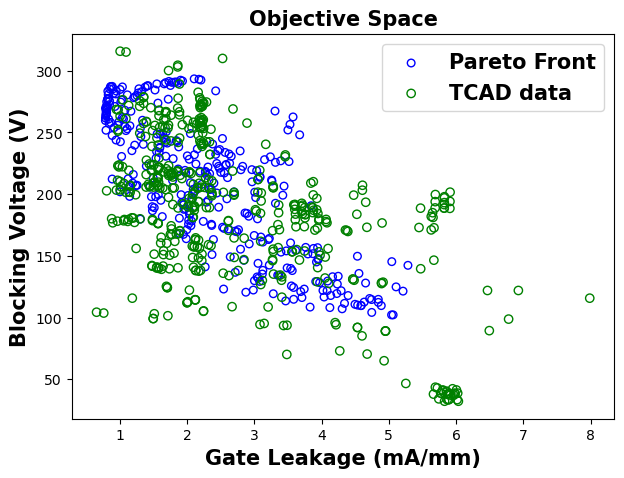

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], -F[:, 0], s=30, facecolors='none', edgecolors='blue', label='Pareto Front')
plt.scatter(y['Leakage_2'], y['BV'], facecolors='none', edgecolors='green', label='TCAD data')
plt.title("Objective Space", size=15, weight='bold')
plt.xlabel('Gate Leakage (mA/mm)', size=15, weight='bold')
plt.ylabel('Blocking Voltage (V)', size=15, weight='bold')
plt.legend(prop={'weight': 'bold', 'size': 15})
plt.savefig('./Plots/Pareto_Front_BV_Leak.pdf', format="pdf", bbox_inches="tight")
plt.show()

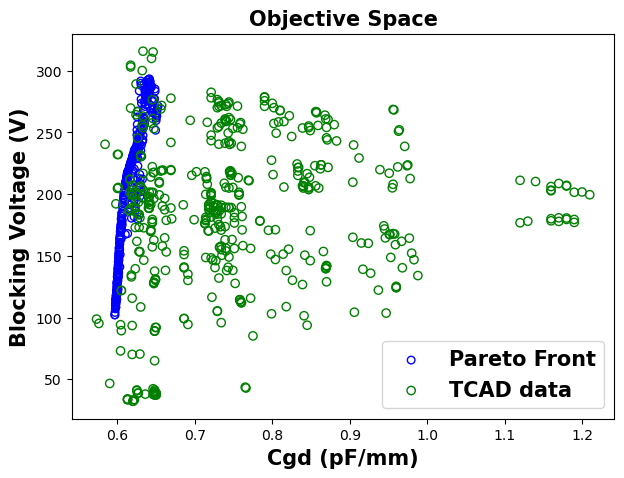

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 2]/1e2, -F[:, 0], s=30, facecolors='none', edgecolors='blue', label='Pareto Front')
plt.scatter(y['Cgd_2']/1e2, y['BV'], facecolors='none', edgecolors='green', label='TCAD data')
plt.title("Objective Space", size=15, weight='bold')
plt.xlabel('Cgd (pF/mm)', size=15, weight='bold')
plt.ylabel('Blocking Voltage (V)', size=15, weight='bold')
plt.legend(prop={'weight': 'bold', 'size': 15})
plt.savefig('./Plots/Pareto_Front_BV_Cgd.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Save
  
 ## Reach 250V
[[3.96728516e-04 4.98168349e-01 6.26450920e+01]

 [2.08312988e-01 1.06548667e-01 6.92192535e+01]
 
 [2.05200195e-01 2.65346479e+00 5.66427383e+01]
 
 [2.41424561e-01 2.52109861e+00 5.65947266e+01]
 
 [1.83685303e-01 4.94403005e-01 6.25380402e+01]]
 
[[0.4        0.2320333  0.38656533 2.4739067  0.6645084  0.59494673
  0.12815331]
  
 [0.4        0.25610369 0.1010883  2.4534966  0.62048792 0.53400841
  0.11195375]
  
 [0.4        0.2000045  0.10157429 2.25553666 0.61826098 0.24192635
  0.00689098]
  
 [0.4        0.200001   0.10157429 2.25553666 0.62154759 0.24192635
  0.00394859]
  
 [0.4        0.2320333  0.37595828 2.4739067  0.6645084  0.59494673
  0.12815331]]

In [71]:
#Target 250V 
print(F[F[:, 0] < 0.5])
print(X[F[:, 0] < 0.5][:, 1:])

[[3.05175781e-05 2.06023335e+00 8.08088074e+01]
 [1.84631348e-03 1.83211875e+00 9.01716232e+01]
 [2.59399414e-04 3.50931835e+00 6.60974731e+01]
 [4.24758911e-01 3.55624139e-01 6.36351242e+01]
 [2.40478516e-01 3.89940560e-01 6.33076935e+01]
 [1.34445190e-01 9.48278487e-01 6.08291817e+01]
 [3.94287109e-02 3.98929417e-01 6.33566170e+01]
 [2.93350220e-01 4.25420940e-01 6.25779991e+01]
 [2.17819214e-01 4.35678899e-01 6.26856728e+01]
 [1.45675659e-01 3.56027067e-01 6.35987244e+01]
 [2.59933472e-01 6.63202584e-01 6.10822449e+01]
 [2.77465820e-01 5.77018440e-01 6.17728386e+01]
 [1.14013672e-01 6.03897631e-01 6.17386894e+01]
 [1.83074951e-01 6.28886402e-01 6.11328735e+01]
 [4.31396484e-01 7.50845253e-01 6.08808098e+01]
 [2.24151611e-02 7.52496302e-01 6.08534126e+01]
 [4.27459717e-01 3.84992421e-01 6.20905075e+01]
 [2.60925293e-02 6.12685621e-01 6.13368225e+01]
 [4.74716187e-01 7.01818764e-01 6.10331879e+01]
 [9.18426514e-02 6.20748937e-01 6.12622604e+01]
 [4.81994629e-01 6.04407251e-01 6.115813

In [51]:
#Target 250V 
print( F[(F[:, 0]> 0.5) * (F[:, 0]< 0.6)])
print( X[(F[:, 0]> 0.5) * (F[:, 0]< 0.6)])
#print(F[F[:, 0] < 0.6])
#print(X[F[:, 0] < 0.6])

[[ 0.59562683  0.75974876 60.81034088]
 [ 0.54710388  1.00129795 60.60240936]
 [ 0.53158569  0.46568805 61.79220963]]
[[0.4        0.20032659 0.20065433 2.28917027 0.46022166 0.33384939
  0.04381966]
 [0.4        0.20049302 0.20135125 2.27794226 0.40799965 0.30374249
  0.04262952]
 [0.4        0.20004642 0.57811911 2.28510169 1.08707441 0.34662904
  0.09167485]]


In [299]:
F

array([[1.69506241e+02, 3.26070523e+00, 6.02103844e+01],
       [1.02216675e+02, 6.39555407e+00, 5.97172012e+01],
       [1.06441452e+02, 5.51596820e-01, 1.00368958e+02],
       [8.06507111e+01, 6.40227854e-01, 1.13556465e+02],
       [1.68864838e+02, 4.42744303e+00, 5.82133141e+01],
       [7.78198242e-04, 2.44035292e+00, 6.25194702e+01],
       [1.40011597e+01, 1.19199455e+00, 7.72672882e+01],
       [8.22601318e-02, 1.27869916e+00, 6.39382095e+01],
       [2.79067535e+01, 4.79571104e+00, 6.18919373e+01],
       [3.39363251e+01, 8.82621348e-01, 1.06736015e+02],
       [4.30016632e+01, 5.25700474e+00, 6.05131187e+01],
       [3.68829498e+01, 8.58945966e-01, 1.10891129e+02],
       [1.00374237e+02, 5.57664931e-01, 1.02352928e+02],
       [4.90391541e+01, 3.02421641e+00, 6.08969307e+01],
       [1.16525955e+02, 5.90994120e-01, 9.55008698e+01],
       [5.93735199e+01, 9.70880568e-01, 8.87945709e+01],
       [7.84351807e+01, 7.48803735e-01, 9.09593964e+01],
       [1.60095032e+02, 2.54507

In [364]:
print(F[F[:, 0] < 10])
print(X[F[:, 0] < 10])

[[1.12457275e-02 4.17054272e+00 6.02154007e+01]
 [3.25012207e-03 1.29833913e+00 9.19363937e+01]
 [9.37576294e-01 1.16792858e+00 8.97037277e+01]
 [9.62219238e-01 5.41349053e-01 8.71255417e+01]
 [1.12229919e+00 1.59417009e+00 6.51926346e+01]
 [3.78178406e+00 3.85566616e+00 6.01687965e+01]
 [3.57594299e+00 2.33010411e+00 6.31639862e+01]
 [8.64089966e-01 1.13139153e+00 9.04194565e+01]
 [9.29815674e+00 6.11195147e-01 8.66187210e+01]
 [1.78131104e-01 3.98931694e+00 6.02952003e+01]
 [3.33805847e+00 4.07416439e+00 6.01049767e+01]
 [7.75656128e+00 2.42040491e+00 6.28706818e+01]
 [1.16163635e+00 2.62328529e+00 6.27456627e+01]
 [8.09854126e+00 1.30672610e+00 8.27662277e+01]
 [5.65870667e+00 3.49726319e+00 6.02491493e+01]
 [6.78002930e+00 1.26463377e+00 8.27718048e+01]]
[[4.00000000e-01 2.06703987e-01 1.13239768e-01 2.26232704e+00
  1.03965420e-01 5.96452219e-01 5.99852904e-04]
 [4.00000000e-01 7.30155513e-01 1.27128339e-01 2.83533052e+00
  4.06809064e-01 5.86005631e-01 1.21837400e-01]
 [4.0000000

In [172]:
F

array([[5.11363068e+01, 3.04275036e+00, 5.45980988e+01],
       [1.00708008e-03, 1.84644377e+00, 5.88300133e+01],
       [1.58458344e+02, 6.50788784e-01, 8.33183289e+01],
       [3.07440796e+01, 1.28012434e-01, 1.11820496e+02],
       [8.57711792e-01, 3.17884827e+00, 5.81679420e+01],
       [1.05539902e+02, 7.42766619e-01, 9.67684708e+01],
       [1.19490036e+02, 8.26965332e-01, 7.83220291e+01],
       [1.61950226e+01, 1.57108784e+00, 6.63206635e+01],
       [8.32357788e+01, 1.31297970e+00, 6.16806755e+01],
       [2.80977478e+01, 8.97098541e-01, 9.08780289e+01],
       [1.51493835e+02, 7.00997353e-01, 8.73830490e+01],
       [7.27759857e+01, 1.18452501e+00, 6.87690277e+01],
       [7.89228058e+01, 1.07233703e+00, 7.22092896e+01],
       [1.32240448e+02, 8.87159824e-01, 7.31408005e+01],
       [5.79989624e+00, 2.24119258e+00, 5.62240028e+01],
       [6.47252808e+01, 1.30445123e+00, 6.35760193e+01],
       [1.00489594e+02, 9.68945146e-01, 7.67178268e+01],
       [3.46229858e+01, 3.93401

In [463]:
len(X)

53

# Inverse Design

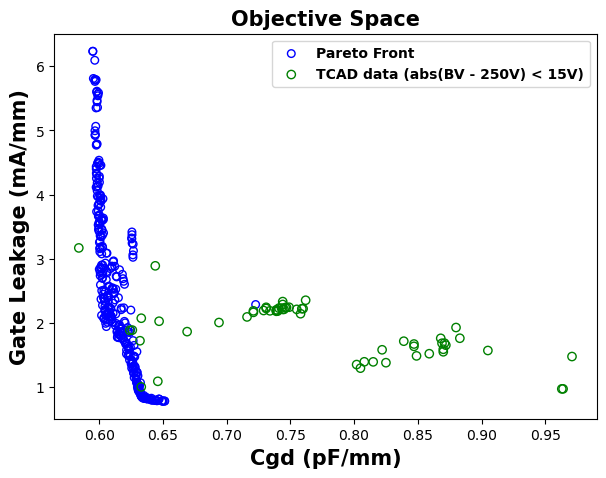

In [20]:
#Reach 250V
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 2]/1e2, F[:, 1], s=30, facecolors='none', edgecolors='blue', label='Pareto Front')
plt.scatter(y[abs(y['BV'] - 250) <= 15]['Cgd_2']/1e2, y[abs(y['BV'] - 250) <= 15]['Leakage_2'],
            facecolors='none', edgecolors='green', label='TCAD data (abs(BV - 250V) < 15V)')
plt.title("Objective Space", size=15, weight='bold')
plt.xlabel('Cgd (pF/mm)', size=15, weight='bold')
plt.ylabel('Gate Leakage (mA/mm)', size=15, weight='bold')
plt.legend(prop={'weight': 'bold', 'size': 10})
plt.savefig('./Plots/Pareto_Front_Target250.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Model Leakage Predict

In [62]:
#model = torch.load('full_model.pth')
#model = torch.load('./Ray_GaN_Best_Opt.pth', map_location=torch.device(device))
model = torch.load('Ray_GaN_Best_Opt_200_100_20_dr4_ba8_3hid4leak.pth', map_location=torch.device(device))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (SharedLinear): Linear(in_features=7, out_features=200, bias=True)
  (NN_stack_1): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ELU(alpha=1.0)
    (5): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=100, out_features=15, bias=True)
    (8): Softplus(beta=1, threshold=20)
    (9): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Linear(in_features=15, out_features=1, bias=True)
  )
  (NN_stack_2): Sequential(
    (0): Softplus(beta=1, threshold=20)
    (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=20, bias=True)
    (4): Softp

In [51]:
test = torch.tensor([0.4, 0.20, 0.58, 2.26, 0.48, 0.30, 0.13])
test_std = scaler.transform([test])
test_std = torch.tensor(test_std, dtype=torch.float32).to(device)

/homes/xiang/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [52]:
model.eval().to(device)
with torch.no_grad():
    res = model(test_std[0:1])
res

(tensor([[291.6830]], device='cuda:0'),
 tensor([[0.1141]], device='cuda:0'),
 tensor([[61.4791]], device='cuda:0'))

In [53]:
data_model = pd.read_csv('./model_data.csv', sep='\t')
data_model['BV_NN'] = 0
data_model['Leak_NN'] = 0
data_model['Cgd'] = 0
data_model.head()

,Lstepl,Lstepr,Thick_GP,SFP_Loc,Len_SFP,SFP_Thick,Oxide_Thick,BV_NN,Leak_NN,Cgd
0,0.4,0.20,0.2,2.31,0.41,0.54,0.13,0,0,0
1,0.4,0.23,0.2,2.37,0.40,0.51,0.12,0,0,0
2,0.4,0.21,0.2,2.40,0.46,0.49,0.12,0,0,0
3,0.4,0.23,0.2,2.36,0.41,0.51,0.12,0,0,0
4,0.4,0.20,0.2,2.36,0.40,0.49,0.12,0,0,0


In [54]:
for i in range(len(data_model)):    
    test = torch.tensor(data_model.iloc[i])[:7]
    test_std = scaler.transform([test])
    test_std = torch.tensor(test_std, dtype=torch.float32).to(device)
    model.eval().to(device)
    with torch.no_grad():
        res = model(test_std[0:1])
    data_model['BV_NN'][i] = res[0].cpu().detach().numpy()[0][0]
    data_model['Leak_NN'][i] = res[1].cpu().detach().numpy()[0][0]
    data_model['Cgd'][i] = res[2].cpu().detach().numpy()[0][0]

/tmp/ipykernel_2171597/3135672272.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test = torch.tensor(data_model.iloc[i])[:7]
/homes/xiang/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_2171597/3135672272.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['BV_NN'][i] = res[0].cpu().detach().numpy()[0][0]
/tmp/ipykernel_2171597/3135672272.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

In [42]:
data_model

,Lstepl,Lstepr,Thick_GP,SFP_Loc,Len_SFP,SFP_Thick,Oxide_Thick,BV_NN,Leak_NN,Cgd
0,0.4,0.20,0.20,2.31,0.41,0.54,0.13,277.018127,1.270207,64.039841
1,0.4,0.23,0.20,2.37,0.40,0.51,0.12,285.461731,1.025112,65.580376
2,0.4,0.21,0.20,2.40,0.46,0.49,0.12,285.874847,0.925321,64.720879
3,0.4,0.23,0.20,2.36,0.41,0.51,0.12,285.803162,1.020153,65.536095
4,0.4,0.20,0.20,2.36,0.40,0.49,0.12,284.124817,0.949832,64.179741
...,...,...,...,...,...,...,...,...,...,...
57,0.4,0.20,0.20,2.30,0.42,0.36,0.04,240.223373,1.863111,62.601196
58,0.4,0.20,0.20,2.29,0.42,0.35,0.04,239.857788,1.878100,62.575565
59,0.4,0.20,0.21,2.35,0.63,0.39,0.06,233.719437,1.566923,63.135101
60,0.4,0.20,0.20,2.35,0.42,0.37,0.05,246.466873,1.726046,63.036324


In [55]:
data_model.to_csv('./model_data_NN1.csv')